### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
from models.ResUNet_plus3_CRF import CompNet as ResUNet_3p_CRF

random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [5]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [6]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [7]:
train_images = glob.glob('/data/segmentation/ISIC-2017/trainset/images/*')
train_labels = glob.glob('/data/segmentation/ISIC-2017/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/ISIC-2017/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/ISIC-2017/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

# train_images = sorted(train_images)
# train_labels = sorted(train_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)
        
# valid_images = sorted(valid_images)
# valid_labels = sorted(valid_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)### dataset class check
# > RGB 채널 평균 값이라 색 바뀜

My custom training-dataset has 2000 elements
My custom valing-dataset has 150 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

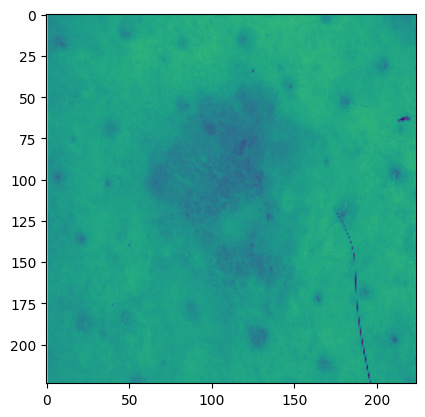

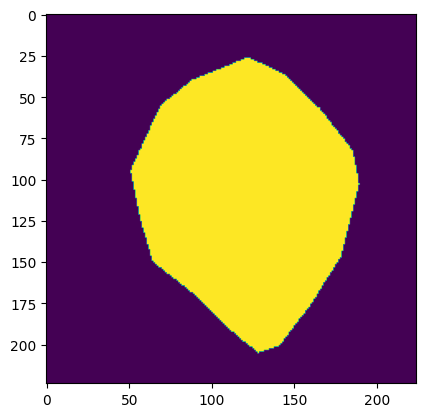

3픽셀의 평균값이라 색깔이 변경됨.


In [8]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')### dataset class check
# > RGB 채널 평균 값이라 색 바뀜

# 3. 모델 클래스 생성

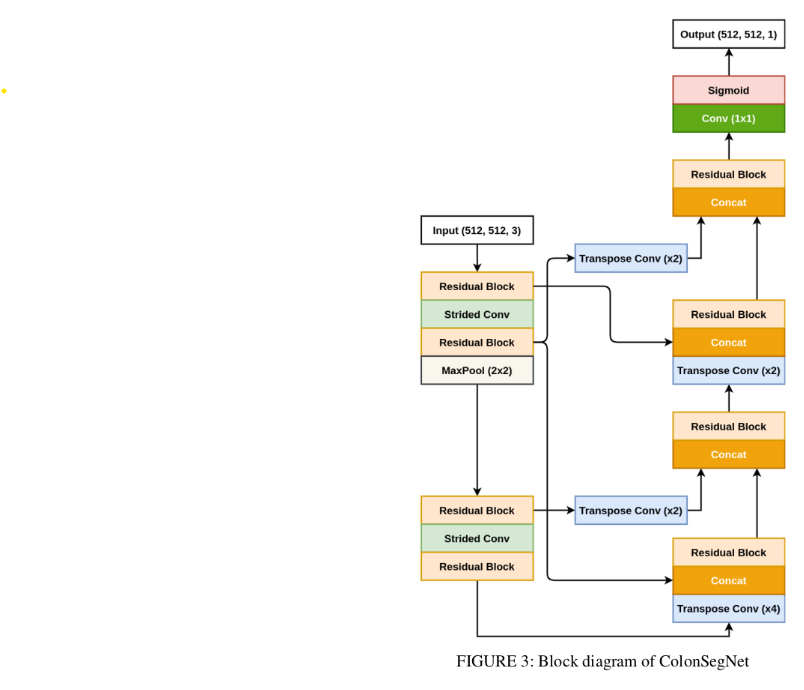

**crf : conditional Random Field**
- 조건부 무작위장, 입력 자기장에 대한 출력 자기장의 조건부 확률과도 같은 것
- 패턴 학습, 기계학습, 컴퓨터 비전과 같은 구조적 예측에 사용되는 통계적 모델링 방법

In [9]:
# Begin training
model = ResUNet_3p_CRF()
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [10]:
# Define variables for the training
epochs = 50
patience = 10
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = DiceBCELoss()
model_name = 'ResUNet_3p_CRF_DiceBCELoss_baseline'


# 5. Training

In [12]:
def dice_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = 2 * (intersection + SMOOTH) / (intersection + union + SMOOTH) # We smooth our devision to avoid 0/0

    return dice.mean()

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 0 of 50, Iter.: 250 of 250, Train Loss: 0.812397, IoU: 0.567990, Dice: 0.678922
 Epoch: 0 of 50, Iter.: 250 of 250, Valid Loss: 0.754041, IoU: 0.587897, Dice: 0.703647

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


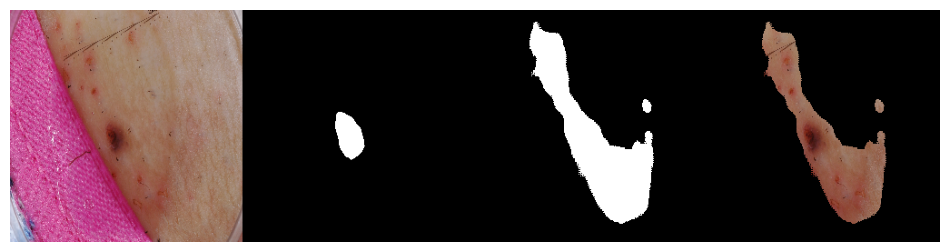

 Epoch: 1 of 50, Iter.: 250 of 250, Train Loss: 0.567146, IoU: 0.664607, Dice: 0.766006
 Epoch: 1 of 50, Iter.: 250 of 250, Valid Loss: 0.668953, IoU: 0.603272, Dice: 0.716090


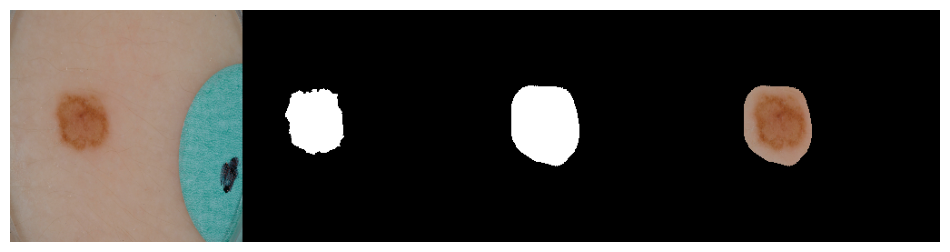

 Epoch: 2 of 50, Iter.: 250 of 250, Train Loss: 0.469663, IoU: 0.695576, Dice: 0.790180
 Epoch: 2 of 50, Iter.: 250 of 250, Valid Loss: 0.619925, IoU: 0.590041, Dice: 0.708148


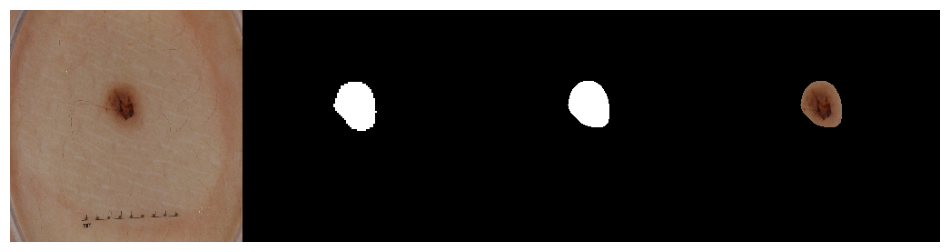

 Epoch: 3 of 50, Iter.: 250 of 250, Train Loss: 0.416773, IoU: 0.714261, Dice: 0.805037
 Epoch: 3 of 50, Iter.: 250 of 250, Valid Loss: 0.535303, IoU: 0.679135, Dice: 0.768013


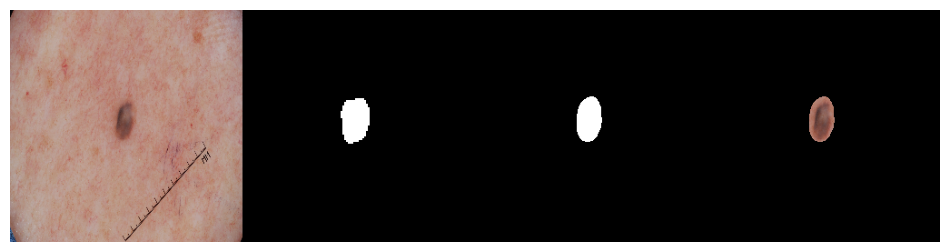

 Epoch: 4 of 50, Iter.: 250 of 250, Train Loss: 0.377141, IoU: 0.727533, Dice: 0.815373
 Epoch: 4 of 50, Iter.: 250 of 250, Valid Loss: 0.522053, IoU: 0.665901, Dice: 0.754005


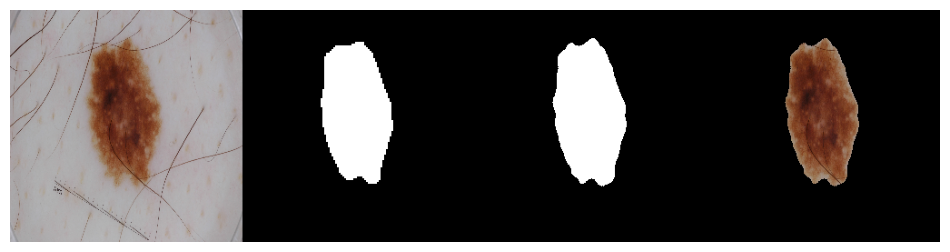

 Epoch: 5 of 50, Iter.: 250 of 250, Train Loss: 0.358201, IoU: 0.737109, Dice: 0.821773
 Epoch: 5 of 50, Iter.: 250 of 250, Valid Loss: 0.526291, IoU: 0.660235, Dice: 0.752735


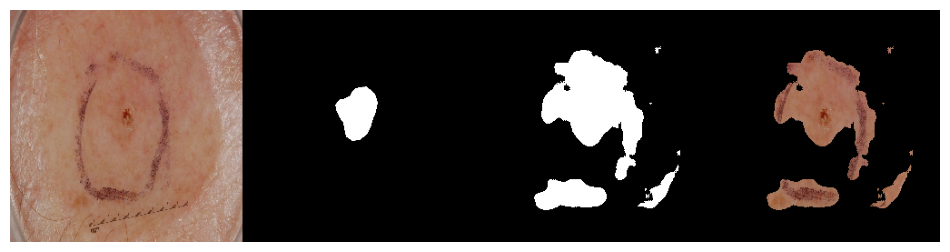

 Epoch: 6 of 50, Iter.: 250 of 250, Train Loss: 0.327758, IoU: 0.749976, Dice: 0.830505
 Epoch: 6 of 50, Iter.: 250 of 250, Valid Loss: 0.506326, IoU: 0.670936, Dice: 0.757252


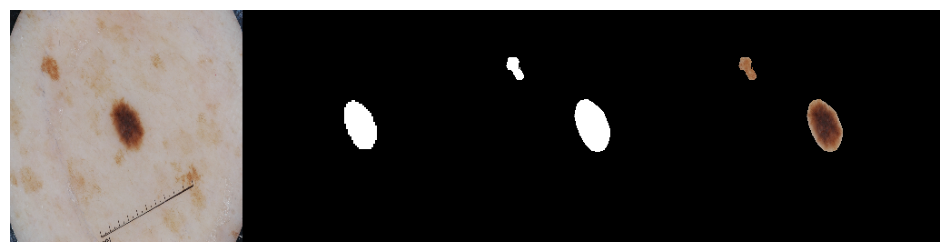

 Epoch: 7 of 50, Iter.: 250 of 250, Train Loss: 0.316076, IoU: 0.751754, Dice: 0.833304
 Epoch: 7 of 50, Iter.: 250 of 250, Valid Loss: 0.542301, IoU: 0.653957, Dice: 0.743918


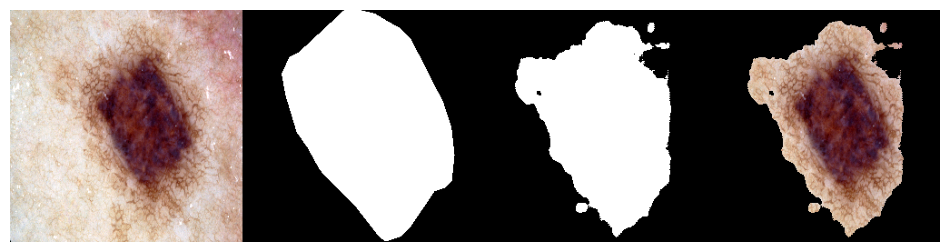

 Epoch: 8 of 50, Iter.: 250 of 250, Train Loss: 0.305197, IoU: 0.756623, Dice: 0.836634
 Epoch: 8 of 50, Iter.: 250 of 250, Valid Loss: 0.694626, IoU: 0.591406, Dice: 0.671447


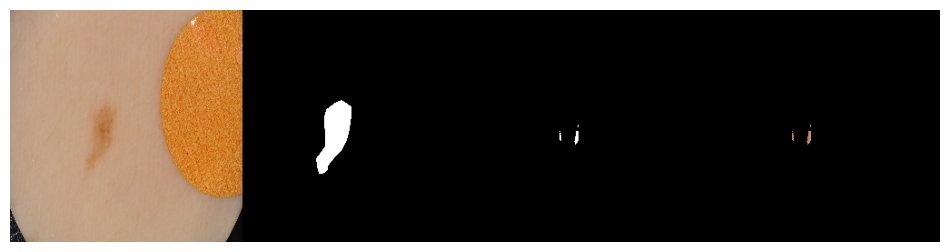

 Epoch: 9 of 50, Iter.: 250 of 250, Train Loss: 0.291176, IoU: 0.763860, Dice: 0.841760
 Epoch: 9 of 50, Iter.: 250 of 250, Valid Loss: 0.489010, IoU: 0.690804, Dice: 0.776378


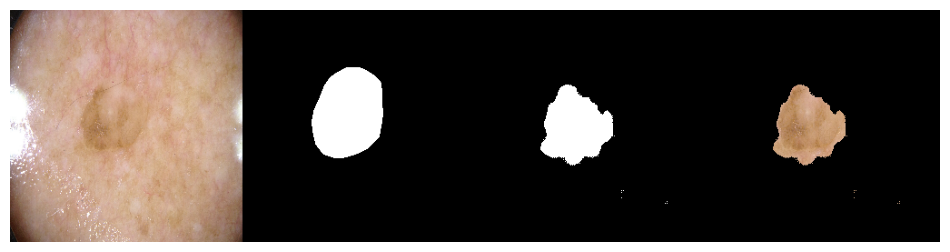

 Epoch: 10 of 50, Iter.: 250 of 250, Train Loss: 0.279283, IoU: 0.770642, Dice: 0.846971
 Epoch: 10 of 50, Iter.: 250 of 250, Valid Loss: 0.582813, IoU: 0.646302, Dice: 0.725355


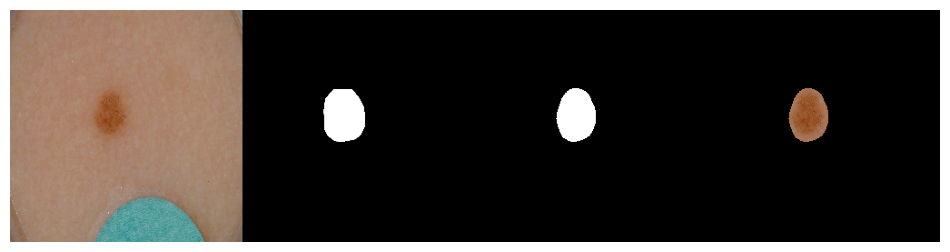

 Epoch: 11 of 50, Iter.: 250 of 250, Train Loss: 0.273260, IoU: 0.776519, Dice: 0.851459
 Epoch: 11 of 50, Iter.: 250 of 250, Valid Loss: 0.551705, IoU: 0.648896, Dice: 0.724523


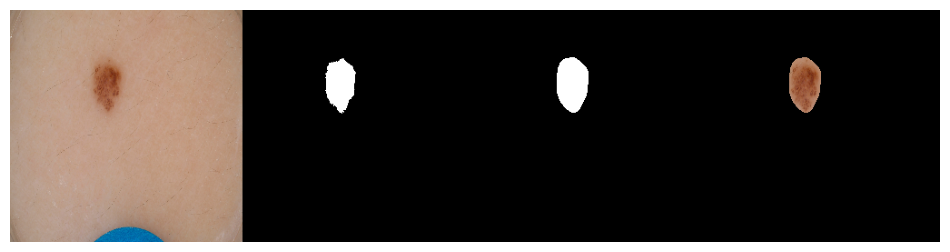

 Epoch: 12 of 50, Iter.: 250 of 250, Train Loss: 0.268473, IoU: 0.780877, Dice: 0.853954
 Epoch: 12 of 50, Iter.: 250 of 250, Valid Loss: 0.509813, IoU: 0.666063, Dice: 0.748499


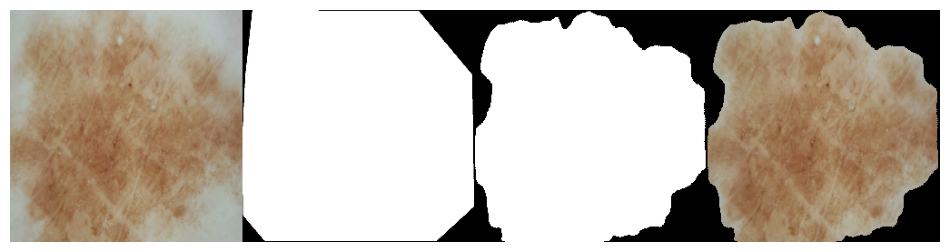

 Epoch: 13 of 50, Iter.: 250 of 250, Train Loss: 0.256961, IoU: 0.781874, Dice: 0.855286
 Epoch: 13 of 50, Iter.: 250 of 250, Valid Loss: 0.449127, IoU: 0.704889, Dice: 0.785702


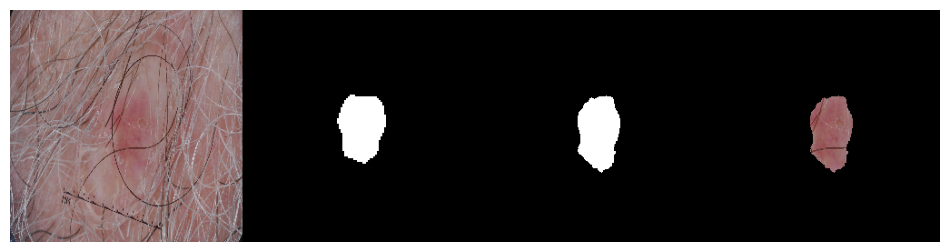

 Epoch: 14 of 50, Iter.: 250 of 250, Train Loss: 0.256154, IoU: 0.782758, Dice: 0.856224
 Epoch: 14 of 50, Iter.: 250 of 250, Valid Loss: 0.447916, IoU: 0.702576, Dice: 0.785485


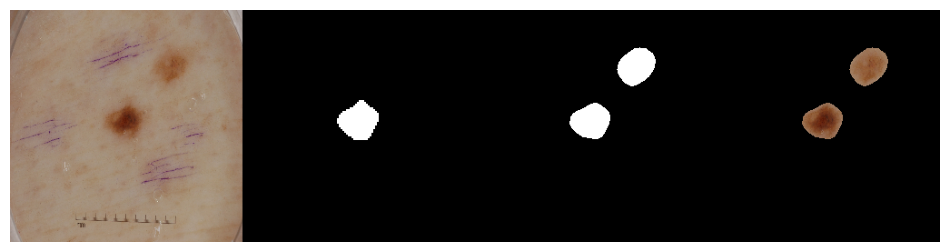

 Epoch: 15 of 50, Iter.: 250 of 250, Train Loss: 0.256749, IoU: 0.786409, Dice: 0.860322
 Epoch: 15 of 50, Iter.: 250 of 250, Valid Loss: 0.481173, IoU: 0.699953, Dice: 0.782892


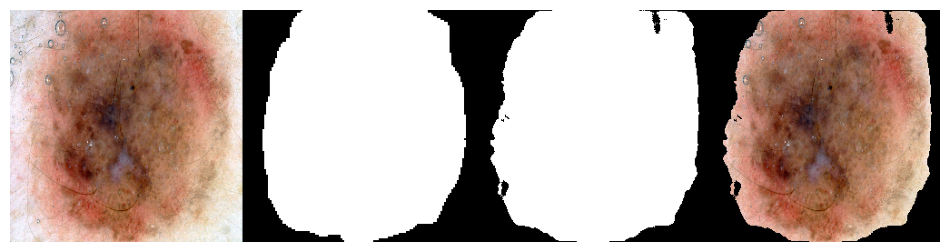

 Epoch: 16 of 50, Iter.: 250 of 250, Train Loss: 0.235551, IoU: 0.796948, Dice: 0.868048
 Epoch: 16 of 50, Iter.: 250 of 250, Valid Loss: 0.429816, IoU: 0.710616, Dice: 0.790277


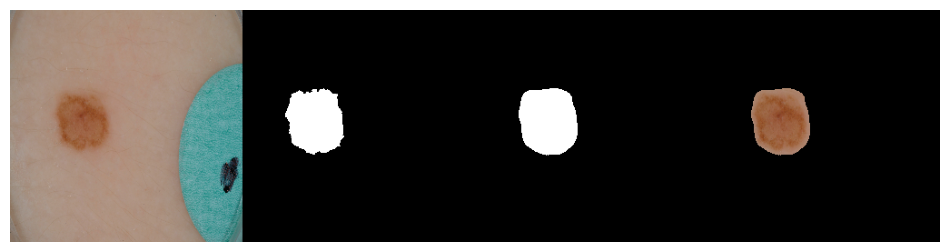

 Epoch: 17 of 50, Iter.: 250 of 250, Train Loss: 0.242801, IoU: 0.792293, Dice: 0.864884
 Epoch: 17 of 50, Iter.: 250 of 250, Valid Loss: 0.537058, IoU: 0.651924, Dice: 0.733677


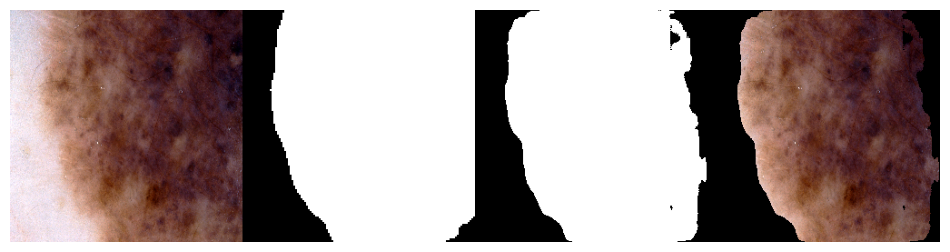

 Epoch: 18 of 50, Iter.: 250 of 250, Train Loss: 0.245028, IoU: 0.791501, Dice: 0.863539
 Epoch: 18 of 50, Iter.: 250 of 250, Valid Loss: 0.496024, IoU: 0.667492, Dice: 0.744592


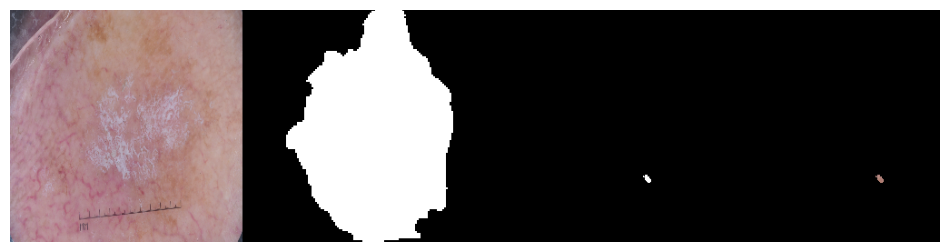

 Epoch: 19 of 50, Iter.: 250 of 250, Train Loss: 0.229318, IoU: 0.798921, Dice: 0.869771
 Epoch: 19 of 50, Iter.: 250 of 250, Valid Loss: 0.492725, IoU: 0.669184, Dice: 0.752585


 Epoch: 20 of 50, Iter.: 250 of 250, Train Loss: 0.230828, IoU: 0.799175, Dice: 0.870475
 Epoch: 20 of 50, Iter.: 250 of 250, Valid Loss: 0.423363, IoU: 0.716109, Dice: 0.799983


 Epoch: 21 of 50, Iter.: 250 of 250, Train Loss: 0.225398, IoU: 0.802544, Dice: 0.873660
 Epoch: 21 of 50, Iter.: 250 of 250, Valid Loss: 0.460441, IoU: 0.705335, Dice: 0.785486


 Epoch: 22 of 50, Iter.: 250 of 250, Train Loss: 0.220512, IoU: 0.804587, Dice: 0.874929
 Epoch: 22 of 50, Iter.: 250 of 250, Valid Loss: 0.453155, IoU: 0.709959, Dice: 0.790119


 Epoch: 23 of 50, Iter.: 250 of 250, Train Loss: 0.222417, IoU: 0.800991, Dice: 0.870169
 Epoch: 23 of 50, Iter.: 250 of 250, Valid Loss: 0.499424, IoU: 0.686638, Dice: 0.768797


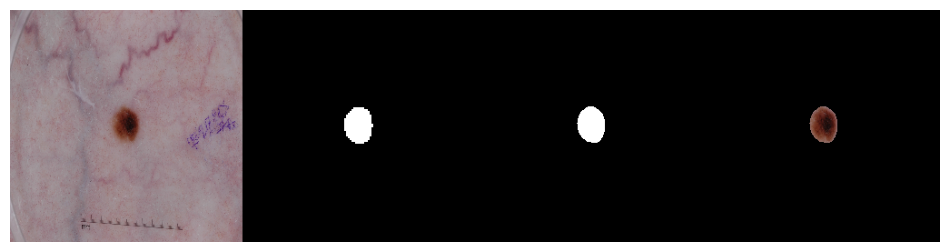

 Epoch: 24 of 50, Iter.: 250 of 250, Train Loss: 0.219697, IoU: 0.804250, Dice: 0.873932
 Epoch: 24 of 50, Iter.: 250 of 250, Valid Loss: 0.459719, IoU: 0.703559, Dice: 0.791017


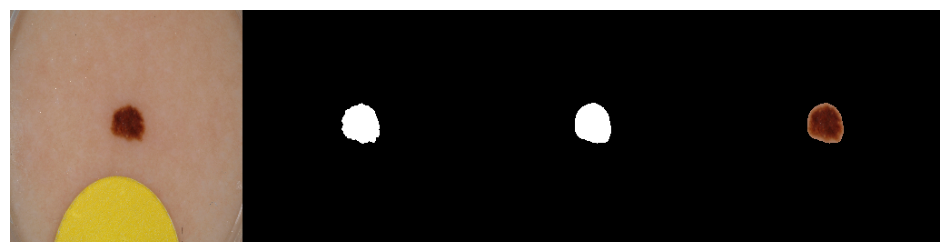

 Epoch: 25 of 50, Iter.: 250 of 250, Train Loss: 0.232224, IoU: 0.797362, Dice: 0.868442
 Epoch: 25 of 50, Iter.: 250 of 250, Valid Loss: 0.453769, IoU: 0.683839, Dice: 0.764054


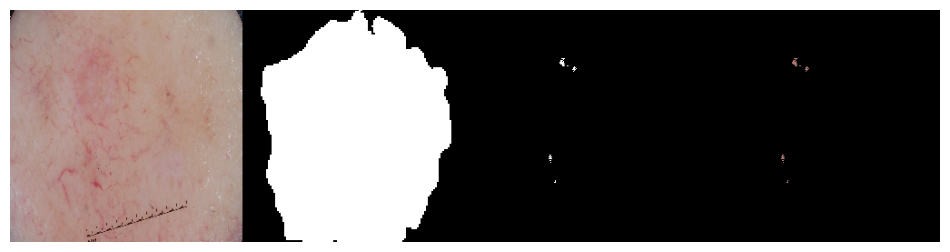

 Epoch: 26 of 50, Iter.: 250 of 250, Train Loss: 0.220109, IoU: 0.801180, Dice: 0.871410
 Epoch: 26 of 50, Iter.: 250 of 250, Valid Loss: 0.475904, IoU: 0.696373, Dice: 0.776031


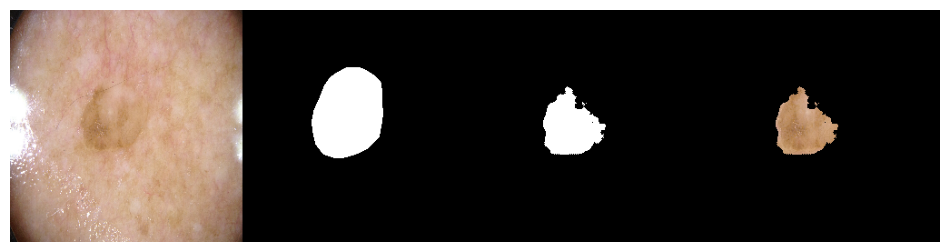

 Epoch: 27 of 50, Iter.: 250 of 250, Train Loss: 0.210821, IoU: 0.811335, Dice: 0.879420
 Epoch: 27 of 50, Iter.: 250 of 250, Valid Loss: 0.452803, IoU: 0.712334, Dice: 0.792715


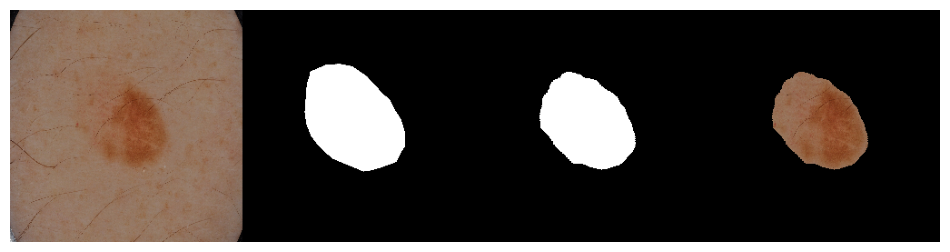

 Epoch: 28 of 50, Iter.: 250 of 250, Train Loss: 0.204515, IoU: 0.814929, Dice: 0.882685
 Epoch: 28 of 50, Iter.: 250 of 250, Valid Loss: 0.436188, IoU: 0.713473, Dice: 0.792906


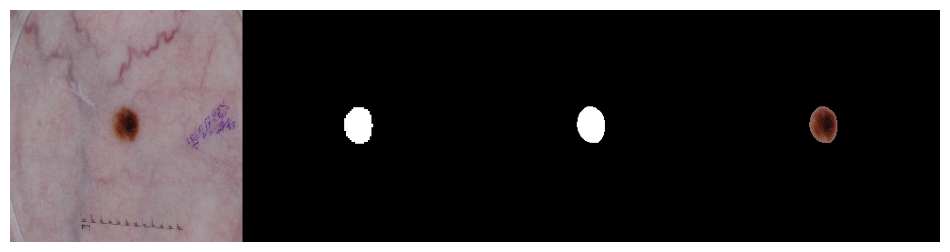

 Epoch: 29 of 50, Iter.: 250 of 250, Train Loss: 0.211870, IoU: 0.810352, Dice: 0.879745
 Epoch: 29 of 50, Iter.: 250 of 250, Valid Loss: 0.443192, IoU: 0.705565, Dice: 0.788095


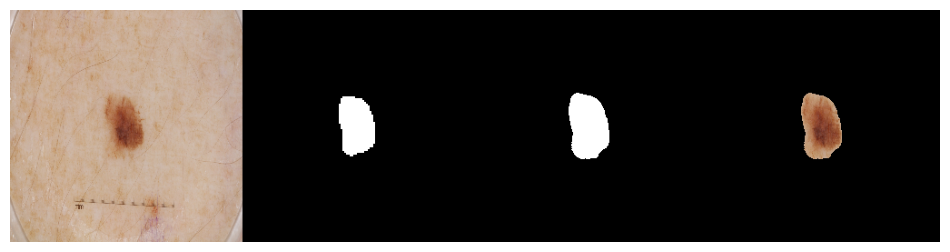

 Epoch: 30 of 50, Iter.: 250 of 250, Train Loss: 0.198826, IoU: 0.814741, Dice: 0.882802
 Epoch: 30 of 50, Iter.: 250 of 250, Valid Loss: 0.540410, IoU: 0.663377, Dice: 0.738802


 Epoch: 31 of 50, Iter.: 250 of 250, Train Loss: 0.193736, IoU: 0.817906, Dice: 0.885587
 Epoch: 31 of 50, Iter.: 250 of 250, Valid Loss: 0.403699, IoU: 0.725432, Dice: 0.805693


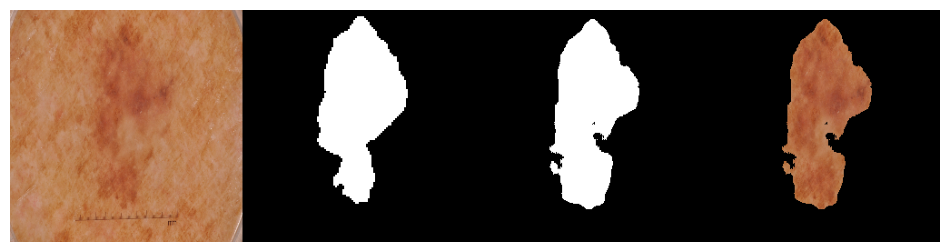

 Epoch: 32 of 50, Iter.: 250 of 250, Train Loss: 0.199300, IoU: 0.815273, Dice: 0.883876
 Epoch: 32 of 50, Iter.: 250 of 250, Valid Loss: 0.480136, IoU: 0.696174, Dice: 0.773100


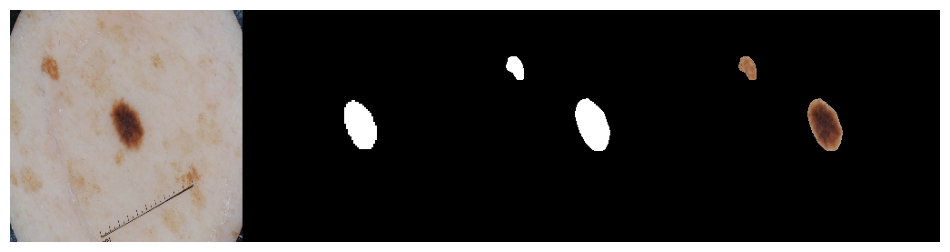

 Epoch: 33 of 50, Iter.: 250 of 250, Train Loss: 0.194386, IoU: 0.818123, Dice: 0.885471
 Epoch: 33 of 50, Iter.: 250 of 250, Valid Loss: 0.444802, IoU: 0.721962, Dice: 0.806788


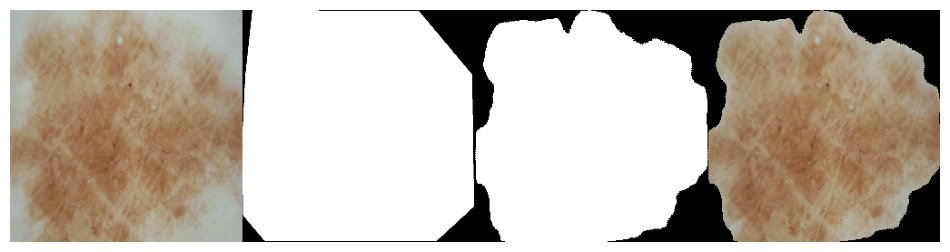

 Epoch: 34 of 50, Iter.: 250 of 250, Train Loss: 0.190633, IoU: 0.822945, Dice: 0.889310
 Epoch: 34 of 50, Iter.: 250 of 250, Valid Loss: 0.468713, IoU: 0.726111, Dice: 0.806273


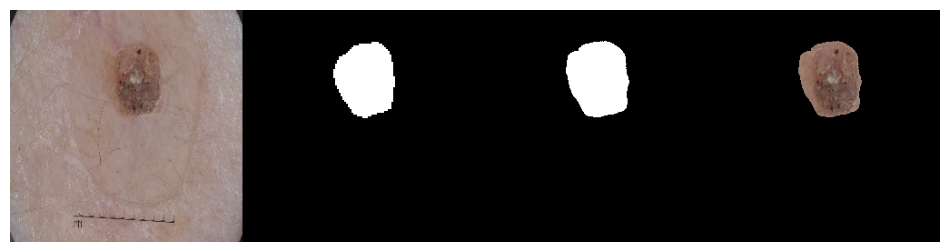

 Epoch: 35 of 50, Iter.: 250 of 250, Train Loss: 0.196013, IoU: 0.819962, Dice: 0.886864
 Epoch: 35 of 50, Iter.: 250 of 250, Valid Loss: 0.394869, IoU: 0.731854, Dice: 0.810864


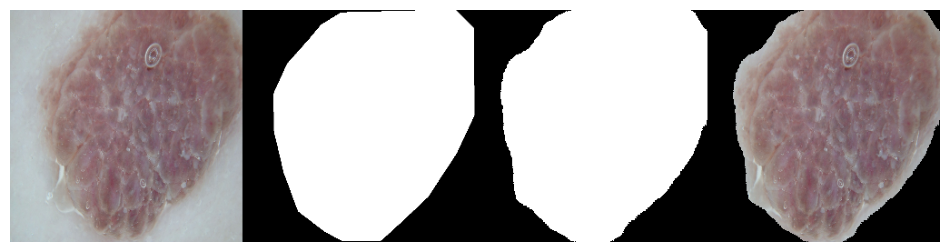

 Epoch: 36 of 50, Iter.: 250 of 250, Train Loss: 0.182917, IoU: 0.828322, Dice: 0.894537
 Epoch: 36 of 50, Iter.: 250 of 250, Valid Loss: 0.503378, IoU: 0.706463, Dice: 0.783540


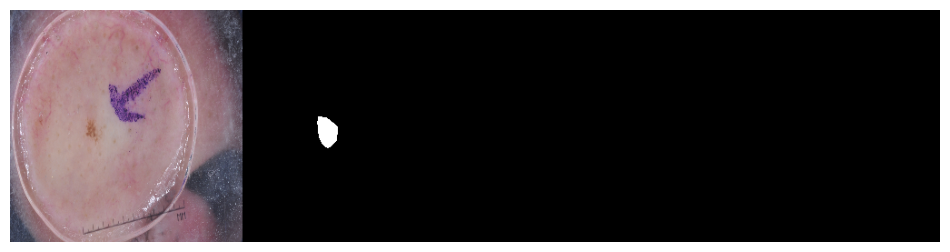

 Epoch: 37 of 50, Iter.: 250 of 250, Train Loss: 0.184837, IoU: 0.822145, Dice: 0.889074
 Epoch: 37 of 50, Iter.: 250 of 250, Valid Loss: 0.420267, IoU: 0.733878, Dice: 0.820321


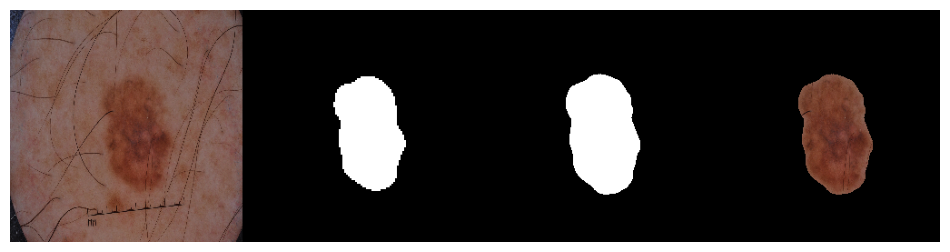

 Epoch: 38 of 50, Iter.: 250 of 250, Train Loss: 0.184210, IoU: 0.828287, Dice: 0.893593
 Epoch: 38 of 50, Iter.: 250 of 250, Valid Loss: 0.424909, IoU: 0.720883, Dice: 0.807942


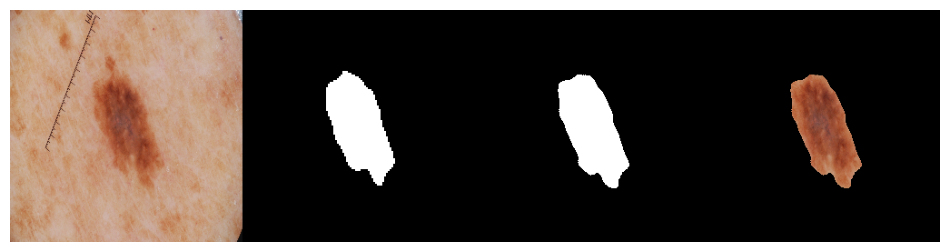

 Epoch: 39 of 50, Iter.: 250 of 250, Train Loss: 0.177286, IoU: 0.830389, Dice: 0.895342
 Epoch: 39 of 50, Iter.: 250 of 250, Valid Loss: 0.547229, IoU: 0.691252, Dice: 0.770635


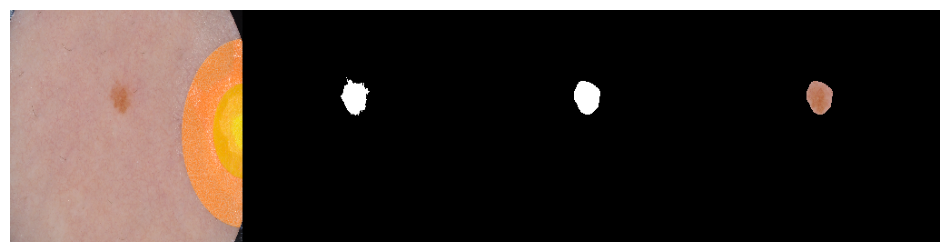

 Epoch: 40 of 50, Iter.: 250 of 250, Train Loss: 0.183271, IoU: 0.826381, Dice: 0.891862
 Epoch: 40 of 50, Iter.: 250 of 250, Valid Loss: 0.470850, IoU: 0.694914, Dice: 0.788489


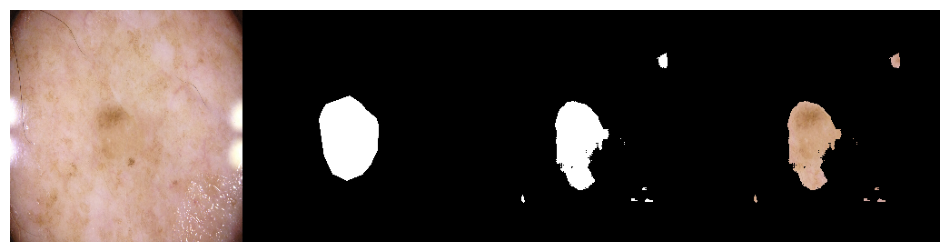

 Epoch: 41 of 50, Iter.: 250 of 250, Train Loss: 0.191788, IoU: 0.820848, Dice: 0.888418
 Epoch: 41 of 50, Iter.: 250 of 250, Valid Loss: 0.459258, IoU: 0.716207, Dice: 0.797852


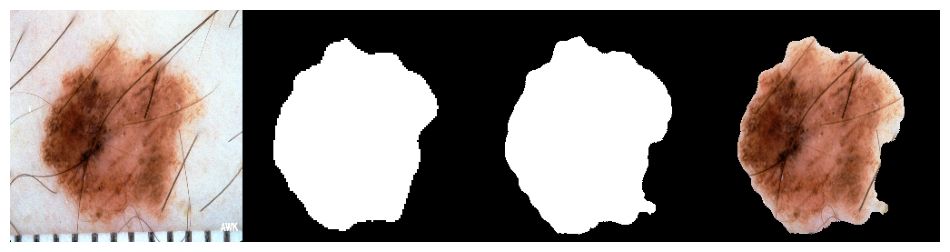

 Epoch: 42 of 50, Iter.: 250 of 250, Train Loss: 0.172521, IoU: 0.830958, Dice: 0.895778
 Epoch: 42 of 50, Iter.: 250 of 250, Valid Loss: 0.478121, IoU: 0.722044, Dice: 0.801579


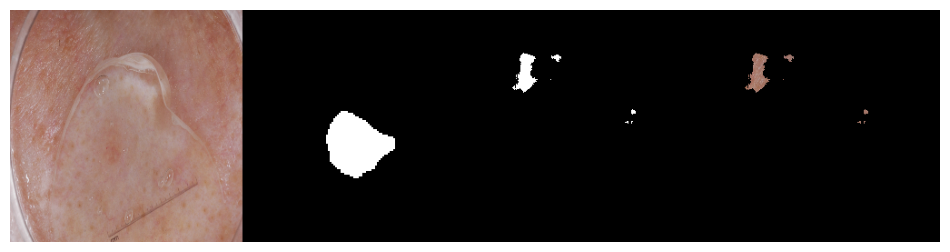

 Epoch: 43 of 50, Iter.: 250 of 250, Train Loss: 0.163627, IoU: 0.839354, Dice: 0.902604
 Epoch: 43 of 50, Iter.: 250 of 250, Valid Loss: 0.524163, IoU: 0.710552, Dice: 0.790420


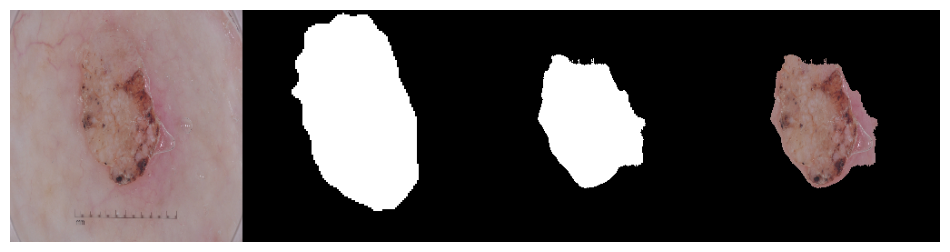

 Epoch: 44 of 50, Iter.: 250 of 250, Train Loss: 0.174273, IoU: 0.830604, Dice: 0.896260
 Epoch: 44 of 50, Iter.: 250 of 250, Valid Loss: 0.470636, IoU: 0.697355, Dice: 0.772564
 Epoch: 45 of 50, Iter.: 250 of 250, Train Loss: 0.185215, IoU: 0.829047, Dice: 0.894243
 Epoch: 45 of 50, Iter.: 250 of 250, Valid Loss: 0.496912, IoU: 0.695796, Dice: 0.773978


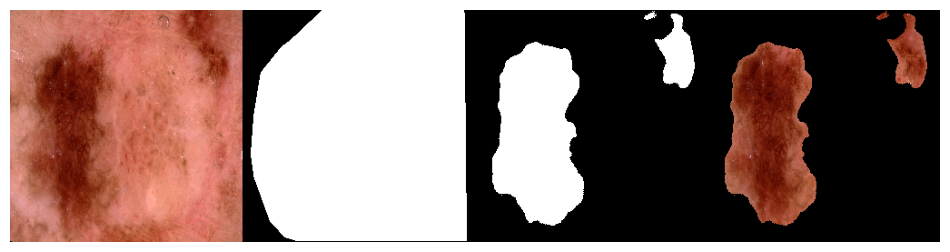

 Epoch: 46 of 50, Iter.: 250 of 250, Train Loss: 0.191566, IoU: 0.821576, Dice: 0.888291
 Epoch: 46 of 50, Iter.: 250 of 250, Valid Loss: 0.463155, IoU: 0.721304, Dice: 0.801259


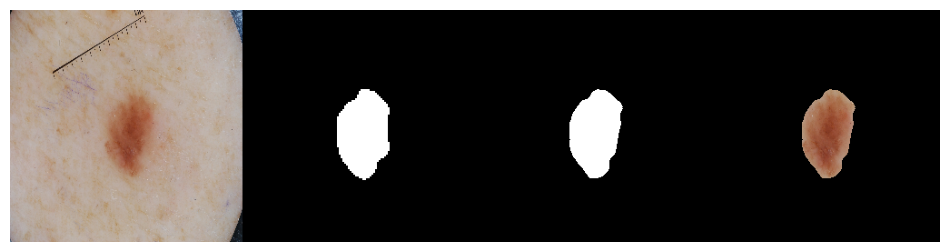

 Epoch: 47 of 50, Iter.: 250 of 250, Train Loss: 0.159857, IoU: 0.841694, Dice: 0.904922
 Epoch: 47 of 50, Iter.: 250 of 250, Valid Loss: 0.427352, IoU: 0.728203, Dice: 0.810530


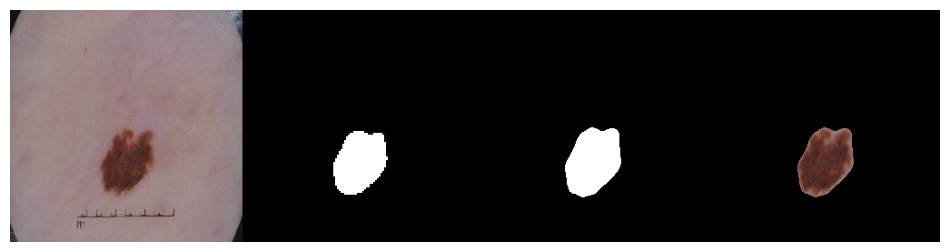

 Epoch: 48 of 50, Iter.: 250 of 250, Train Loss: 0.154398, IoU: 0.844157, Dice: 0.906354
 Epoch: 48 of 50, Iter.: 250 of 250, Valid Loss: 0.384882, IoU: 0.740882, Dice: 0.822590


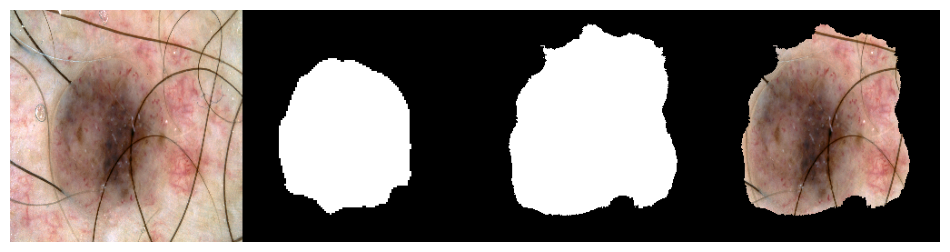

 Epoch: 49 of 50, Iter.: 250 of 250, Train Loss: 0.157911, IoU: 0.842059, Dice: 0.904146
 Epoch: 49 of 50, Iter.: 250 of 250, Valid Loss: 0.435889, IoU: 0.734759, Dice: 0.814017


CPU times: user 18min 6s, sys: 15min 2s, total: 33min 8s
Wall time: 3h 51min 23s


In [13]:

%%time
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test
from ploting import plot_model_prediction

data_name = 'ISIC'

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch = -1
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

for epoch in range(epochs):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 0:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    if epoch+1 % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
        for i, (metric, value) in enumerate(metrics.items()):
            axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=3)
            axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=3)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Loss')
            axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
            axs[i].legend(loc='best')
        plt.show()
    
    lst_epoch_metric.append([round(epoch_train_loss,2), round(epoch_val_loss,2), round(epoch_train_iou,2), 
                             round(epoch_val_iou,2), round(epoch_train_dice,2), round(epoch_val_dice,2)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_iou = epoch if best_iou == epoch_val_iou else best_epoch_iou
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'metric_{model_name}_{data_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_IOU:0.7409, Best_DiceScore:0.8226


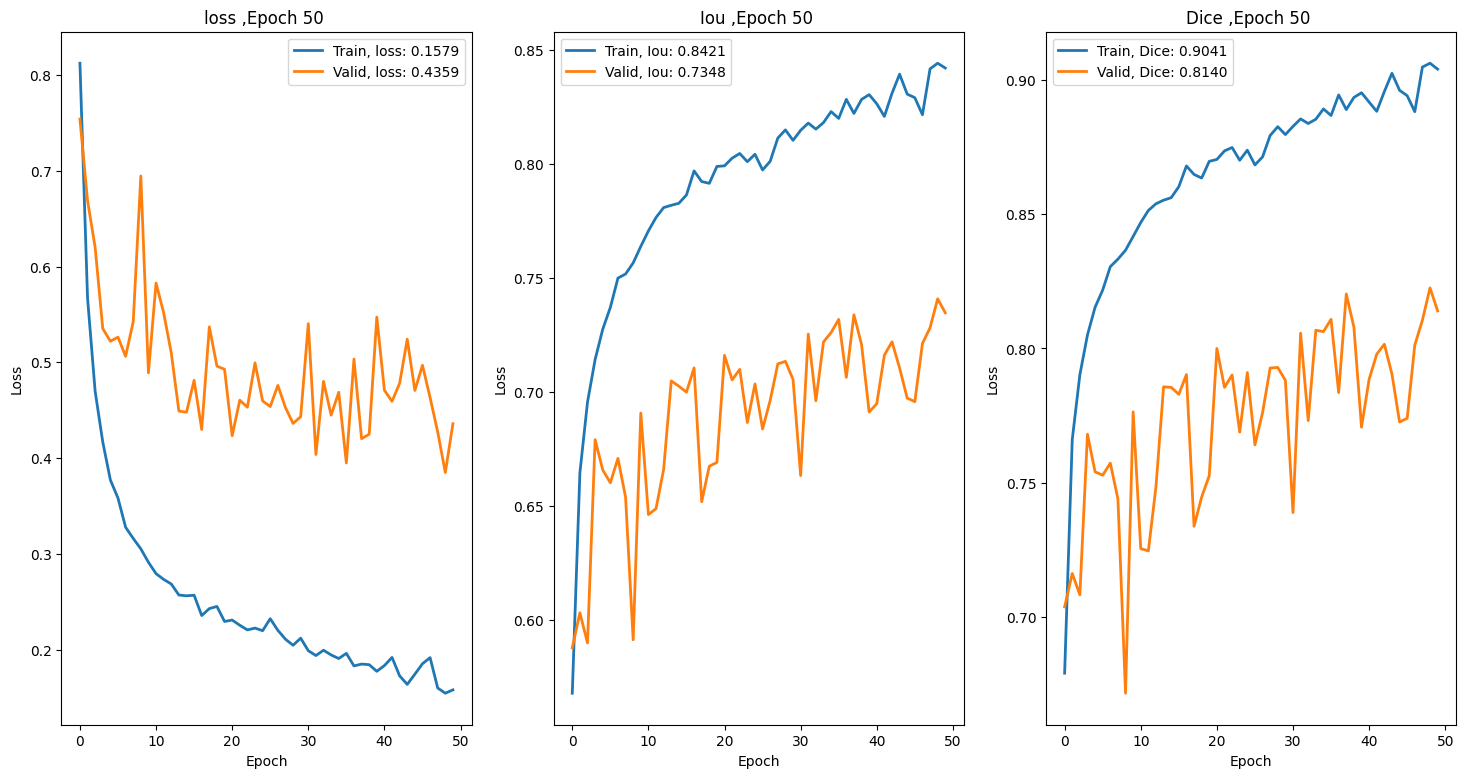

In [14]:
print(f'Validationset 기준 \nBest_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

# metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
#            'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
#            'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
    axs[i].legend(loc='best')
plt.show()